In [1]:
!pip install tonic --quiet # install tonic, snntorch
!pip install snntorch --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 kB 5.4 MB/s eta 0:00:00


In [2]:
import tonic

dataset = tonic.datasets.NMNIST(save_to='./data', train=True) # loading N-MNIST dataset,
events, target = dataset[0]
print(events) # event information in format:  (x-coordinate, y-coordinate, timestamp, polarity)
print(target) # label information
print(dataset[0])
print(len(dataset))

  0%|          | 0/1011893601 [00:00<?, ?it/s]

Extracting ./data/NMNIST/train.zip to ./data/NMNIST
[(16,  9,   1138, 0) (11, 16,   2428, 0) (17,  6,   2953, 1) ...
 (23, 15, 308605, 1) ( 8,  5, 309710, 1) (30, 22, 310333, 1)]
3
(array([(16,  9,   1138, 0), (11, 16,   2428, 0), (17,  6,   2953, 1), ...,
       (23, 15, 308605, 1), ( 8,  5, 309710, 1), (30, 22, 310333, 1)],
      dtype=[('x', '<i8'), ('y', '<i8'), ('t', '<i8'), ('p', '<i8')]), 3)
60000


<ipython-input-3-194db71bbd46>:1: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  tonic.utils.plot_event_grid(events) # visualize events


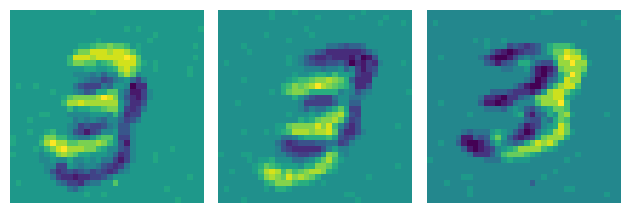

In [3]:
tonic.utils.plot_event_grid(events) # visualize events

In [4]:
import tonic.transforms as transforms

sensor_size = tonic.datasets.NMNIST.sensor_size

# transforms to denoise removes isolated, one-off events
# apply batch time_window to create samples
frame_transform = transforms.Compose([transforms.Denoise(filter_time=10000),
                                      transforms.ToFrame(sensor_size=sensor_size,
                                                         time_window=1000)
                                     ])

trainset = tonic.datasets.NMNIST(save_to='./tmp/data', transform=frame_transform, train=True)
testset = tonic.datasets.NMNIST(save_to='./tmp/data', transform=frame_transform, train=False)

  0%|          | 0/1011893601 [00:00<?, ?it/s]

Extracting ./tmp/data/NMNIST/train.zip to ./tmp/data/NMNIST


  0%|          | 0/169674850 [00:00<?, ?it/s]

Extracting ./tmp/data/NMNIST/test.zip to ./tmp/data/NMNIST


In [5]:
def load_sample_simple():
    for i in range(100):
        events, target = trainset[i]

In [6]:
%timeit -o load_sample_simple()

1.56 s ± 31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 1.56 s ± 31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [7]:
from torch.utils.data import DataLoader # utilize padding and fast loading of data
from tonic import DiskCachedDataset

cached_trainset = DiskCachedDataset(trainset, cache_path='./cache/nmnist/train')
cached_dataloader = DataLoader(cached_trainset)

batch_size = 128
trainloader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors())

In [8]:
def load_sample_batched():
    events, target = next(iter(cached_dataloader))

In [9]:
%timeit -o -r 10 load_sample_batched()

3.85 ms ± 33.4 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


<TimeitResult : 3.85 ms ± 33.4 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)>

In [10]:
import torch
import torchvision

transform = tonic.transforms.Compose([torch.from_numpy,
                                      torchvision.transforms.RandomRotation([-10,10])]) # creating training and test set, mini-batch implementation

cached_trainset = DiskCachedDataset(trainset, transform=transform, cache_path='./cache/nmnist/train')

# no augmentations for the testset
cached_testset = DiskCachedDataset(testset, cache_path='./cache/nmnist/test')

batch_size = 128
trainloader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=True)
testloader = DataLoader(cached_testset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False))

In [11]:
event_tensor, target = next(iter(trainloader))
print(event_tensor[0])
print(event_tensor.shape)

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
        

In [12]:
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import spikeplot as splt
from snntorch import utils
import torch.nn as nn

In [13]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# neuron and simulation parameters
spike_grad = surrogate.atan()
beta = 0.5

#  Initialize Network, 12 filters Conv 5X5-Max Pool 2X2-32 filters Conv 5X5-Max Pool 2X2-800 fully connected 10 o/p
net = nn.Sequential(nn.Conv2d(2, 12, 5),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.MaxPool2d(2),
                    nn.Conv2d(12, 32, 5),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.MaxPool2d(2),
                    nn.Flatten(),
                    nn.Linear(32*5*5, 10),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
                    ).to(device)

In [14]:


def forward_pass(net, data):
  spk_rec = []
  utils.reset(net)  # resets hidden states for all LIF neurons in net

  for step in range(data.size(0)):  # data.size(0) = number of time steps
      spk_out, mem_out = net(data[step])
      spk_rec.append(spk_out)

  return torch.stack(spk_rec)

In [15]:
optimizer = torch.optim.Adam(net.parameters(), lr=2e-2, betas=(0.9, 0.999)) # Adam optimizer
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2) #mean square count loss

In [16]:
num_epochs = 1
num_iters = 200

loss_hist = []
acc_hist = []

# training loop
for epoch in range(num_epochs):
    for i, (data, targets) in enumerate(iter(trainloader)):
        data = data.to(device)
        targets = targets.to(device)

        net.train()
        spk_rec = forward_pass(net, data)
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.2f}")

        acc = SF.accuracy_rate(spk_rec, targets)
        acc_hist.append(acc)
        print(f"Accuracy: {acc * 100:.2f}%\n")

        if i == num_iters:
          break

Epoch 0, Iteration 0 
Train Loss: 31.00
Accuracy: 12.50%

Epoch 0, Iteration 1 
Train Loss: 31.02
Accuracy: 8.59%

Epoch 0, Iteration 2 
Train Loss: 30.90
Accuracy: 10.16%

Epoch 0, Iteration 3 
Train Loss: 30.90
Accuracy: 8.59%

Epoch 0, Iteration 4 
Train Loss: 30.18
Accuracy: 5.47%

Epoch 0, Iteration 5 
Train Loss: 16.50
Accuracy: 12.50%

Epoch 0, Iteration 6 
Train Loss: 14.84
Accuracy: 13.28%

Epoch 0, Iteration 7 
Train Loss: 17.71
Accuracy: 10.16%

Epoch 0, Iteration 8 
Train Loss: 18.63
Accuracy: 17.97%

Epoch 0, Iteration 9 
Train Loss: 15.23
Accuracy: 19.53%

Epoch 0, Iteration 10 
Train Loss: 12.74
Accuracy: 22.66%

Epoch 0, Iteration 11 
Train Loss: 12.57
Accuracy: 22.66%

Epoch 0, Iteration 12 
Train Loss: 14.40
Accuracy: 27.34%

Epoch 0, Iteration 13 
Train Loss: 14.89
Accuracy: 21.09%

Epoch 0, Iteration 14 
Train Loss: 12.81
Accuracy: 31.25%

Epoch 0, Iteration 15 
Train Loss: 12.80
Accuracy: 28.91%

Epoch 0, Iteration 16 
Train Loss: 13.00
Accuracy: 25.00%

Epoch 0, I

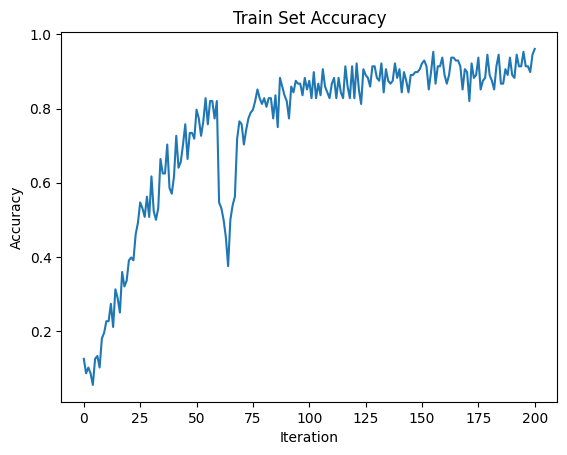

In [17]:
import matplotlib.pyplot as plt # plot test accuracy

# Plot Loss
fig = plt.figure(facecolor="w")
plt.plot(acc_hist)
plt.title("Train Set Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

In [18]:
spk_rec = forward_pass(net, data) # spike counter

The target label is: 3


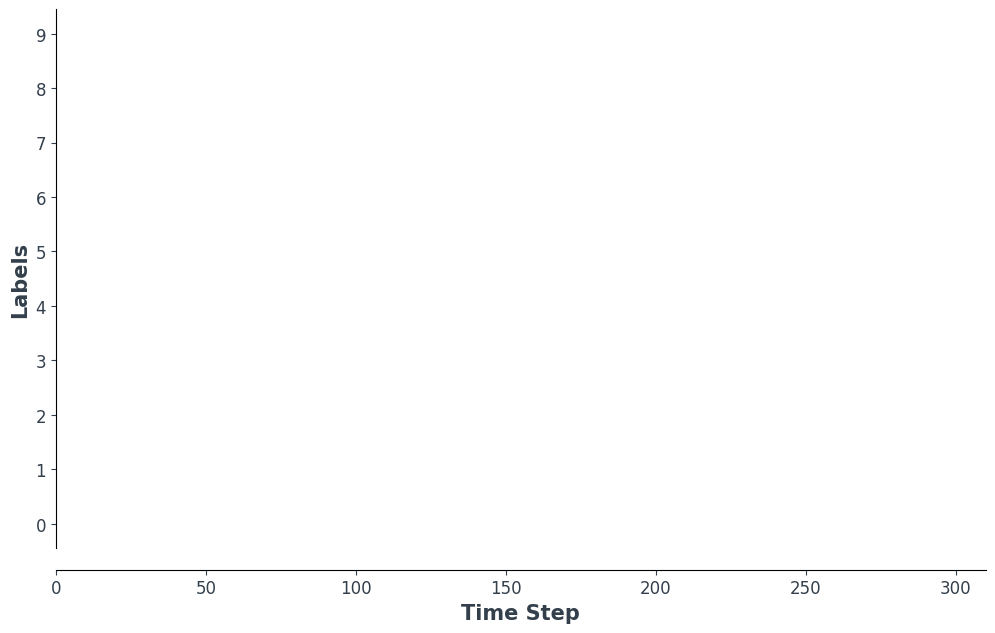

In [19]:
from IPython.display import HTML

idx = 0

fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
labels=['0', '1', '2', '3', '4', '5', '6', '7', '8','9']
print(f"The target label is: {targets[idx]}")

# plt.rcParams['animation.ffmpeg_path'] = 'C:\\path\\to\\your\\ffmpeg.exe'

#  Plot spike count histogram
anim = splt.spike_count(spk_rec[:, idx].detach().cpu(), fig, ax, labels=labels,
                        animate=True, interpolate=1)

HTML(anim.to_html5_video())
# anim.save("spike_bar.mp4")